In [1]:
import torch
import torchvision
import os
import glob
import cv2
import numpy as np
from PIL import Image
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random
import torchvision.transforms.functional as TF
import shutil
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import torch.nn as nn
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.ConvBlock = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True), #inplace=True can slightly reduce memory usage
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.ConvBlock(x)
    
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.ConvBlock = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        s = self.ConvBlock(x) #skip connection
        p = self.pool(s) #pass maxpool2d to next layer of network
        return (p, s)
    
#decoder just for autoencoder, change for UNet
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upConv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)        
        self.ConvBlock = ConvBlock(out_channels, out_channels)

    def forward(self, p):
        x = self.upConv(p)
        return self.ConvBlock(x)
    
#decoder for UNet
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.upConv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)        
        self.ConvBlock = ConvBlock(in_channels, out_channels)

    def forward(self, p, s):
        x = self.upConv(p)
        x = torch.cat([x, s], dim=1)
        return self.ConvBlock(x)

In [3]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()        
        # Encoder
        self.encoder1 = EncoderBlock(1, 64)
        self.encoder2 = EncoderBlock(64, 128)
        self.encoder3 = EncoderBlock(128, 256)
        self.encoder4 = EncoderBlock(256, 512)
        
        # Bottleneck
        self.bottleneck = ConvBlock(512, 1024)
        
        # Decoder
        self.decoder1 = UpBlock(1024, 512)
        self.decoder2 = UpBlock(512, 256)
        self.decoder3 = UpBlock(256, 128)
        self.decoder4 = UpBlock(128, 64)
        
        # Final Layer, take out sigmoid if using BCEWithLogitsLoss
        self.decoded = nn.Sequential(nn.Conv2d(64, 1, 1)
                                     #nn.Sigmoid()
                                    )
        
        
    def forward(self, x):
        p1, s1 = self.encoder1(x)
        p2, s2 = self.encoder2(p1)
        p3, s3 = self.encoder3(p2)
        p4, s4 = self.encoder4(p3)
        
        b = self.bottleneck(p4)
        
        d1 = self.decoder1(b, s4)
        d2 = self.decoder2(d1, s3)
        d3 = self.decoder3(d2, s2)
        d4 = self.decoder4(d3, s1)

        decoded = self.decoded(d4)
        
        return decoded

In [4]:
# custom loss functions from
# https://towardsdatascience.com/how-accurate-is-image-segmentation-dd448f896388#:~:text=Dice%20Coefficient&text=Dice%20coefficient%20is%20a%20measure,while%200%20indicates%20no%20overlap.&text=Dice%20Loss%20%3D%201%20%E2%80%94%20Dice%20Coefficient.
def dice_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

def dice_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    # add sigmoid since we take it out to use BCEWithLogitsLoss
    dicescore = dice_loss(nn.functional.sigmoid(inputs), target)
    bcescore = nn.BCEWithLogitsLoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

In [5]:
model = torch.load("UNetCellpose.pth")
model.to(device)
model.train()
# Validation using MSE Loss function
loss_function = nn.BCEWithLogitsLoss()
#loss_function = nn.MSELoss()
 
# Using an Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 3e-4,
                             weight_decay = 1e-8
                            )

In [6]:
# pathway for image folder
imagePath = "/project/trlab/imagePath"
maskPath = "/project/trlab/maskPath"

# try with single image
#imagePath = "/project/trlab/SingleIm"
#maskPath = "/project/trlab/SingleMask"

imagePaths = []
maskPaths = []
for data_path in sorted(glob.glob(imagePath + '/*')):
    imagePaths.append(data_path)
    
for data_path in sorted(glob.glob(maskPath + '/*')):
    maskPaths.append(data_path)

In [7]:
# Create Dataset class
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, imagePaths, maskPaths):
        # init method takes list of image paths, ground truth masks, and transformations as input
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        
    def transform(self, image, mask):
        # standardize to values between 0 and 1 for faster convergence
        image = image/255.0
        image = image.astype('float32')
        
        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        # Transfer to device
        image = image.to(device)
        mask = mask.to(device)
        
        # Random crop (not gonna do this for this run through since the images are all different sizes)
        i, j, h, w = T.RandomCrop.get_params(image, output_size=(512, 512))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
            
        # Random rotation
        if random.random() > 0.5:
            angle = random.randint(-90,90)
            image = TF.rotate(image,angle)
            mask = TF.rotate(mask,angle)
            
        # Random Gaussian Blur
        if random.random() > 0.5:
            image = TF.gaussian_blur(image, 3, 0.15)
            
        # Random sharpness
        sharpness = random.random()
        shift = random.uniform(0.2,1.8)
        if sharpness > 0.5:
            image = TF.adjust_sharpness(image, shift)
            
        # Random contrast not sure why this isn't working, current documentation says one channel tensors are fine
        # but it's throwing an error saying you need 3 channels
        #contrast = random.random()
        #if contrast > 0.5:
        #    image = TF.adjust_contrast(image, 2)
        #elif contrast < 0.25:
        #    image = TF.adjust_contrast(image, 0.5)
        
        # Random brightness
        brightness = random.random()
        shift = random.uniform(0.2,1.8)
        if brightness > 0.5:
            image = TF.adjust_brightness(image, shift)
            
        # Random Affine
        shearx = random.randint(-45,45)
        sheary = random.randint(-45,45)
        transx = random.randint(-20,20)
        transy = random.randint(-20,20)
        if random.random() > 0.5:
            image = TF.affine(image, translate=(transx,transy), shear=(shearx,sheary), angle=0, scale=1)
            mask = TF.affine(mask, translate=(transx,transy), shear=(shearx,sheary), angle=0, scale=1)
            
        return image, mask
    
    def __len__(self):
        # total number of image paths in dataset
        return len(self.imagePaths)
    
    def __getitem__(self,idx):
        # returns sample from dataset
        imagePath = self.imagePaths[idx]
        maskPath = self.maskPaths[idx]
        
        image = cv2.imdecode(np.fromfile(imagePath, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imdecode(np.fromfile(maskPath, dtype=np.uint8), cv2.IMREAD_UNCHANGED)

        image, mask = self.transform(image, mask)
            
        return (image, mask)

In [8]:
torch.manual_seed(1)

dataset = Dataset(imagePaths = imagePaths,
                  maskPaths = maskPaths
                 )

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = 4,
                                           shuffle = True)
test_dataset.indices
train_dataset.indices

[0, 10, 2, 3, 7, 6, 4, 8, 1]

In [9]:
epochs = 10000
count = 1
outputs = []
losses = []
#test_losses = []

# modify training loop to use automatic mixed precision

# convert model to half precision to save memory
#model.half()

# need to keep batch norm layers at fp32
#for layer in model.modules():
#    if isinstance(layer, nn.BatchNorm2d):
#        layer.float()

scaler = torch.cuda.amp.GradScaler(enabled=True)
    
model.train()
for epoch in range(epochs):
    runningLoss = 0
    for (i,(image, mask)) in enumerate(train_loader):
        
        image = image.to(device)
        mask = mask.to(device)
        
        with torch.cuda.amp.autocast():
            # Output of UNet
            reconstructed = model(image)
       
            # Calculating the loss function
            #loss = loss_function(reconstructed, mask)
            #loss = dice_loss(reconstructed, mask)
            loss = bce_dice_loss(reconstructed, mask)
            runningLoss = runningLoss + loss.item()
            
        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()
        
        # autocast backprop
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
       
    # Storing the losses in a list for plotting
    losses.append(runningLoss/len(train_loader))
    outputs.append((epochs, image, reconstructed))
    print("epoch", count, "finished")
    count = count + 1

/share/pkg.7/pytorch/1.9.0/install/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/share/pkg.7/pytorch/1.9.0/install/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 1 finished
epoch 2 finished
epoch 3 finished
epoch 4 finished
epoch 5 finished
epoch 6 finished
epoch 7 finished
epoch 8 finished
epoch 9 finished
epoch 10 finished
epoch 11 finished
epoch 12 finished
epoch 13 finished
epoch 14 finished
epoch 15 finished
epoch 16 finished
epoch 17 finished
epoch 18 finished
epoch 19 finished
epoch 20 finished
epoch 21 finished
epoch 22 finished
epoch 23 finished
epoch 24 finished
epoch 25 finished
epoch 26 finished
epoch 27 finished
epoch 28 finished
epoch 29 finished
epoch 30 finished
epoch 31 finished
epoch 32 finished
epoch 33 finished
epoch 34 finished
epoch 35 finished
epoch 36 finished
epoch 37 finished
epoch 38 finished
epoch 39 finished
epoch 40 finished
epoch 41 finished
epoch 42 finished
epoch 43 finished
epoch 44 finished
epoch 45 finished
epoch 46 finished
epoch 47 finished
epoch 48 finished
epoch 49 finished
epoch 50 finished
epoch 51 finished
epoch 52 finished
epoch 53 finished
epoch 54 finished
epoch 55 finished
epoch 56 finished
e

epoch 438 finished
epoch 439 finished
epoch 440 finished
epoch 441 finished
epoch 442 finished
epoch 443 finished
epoch 444 finished
epoch 445 finished
epoch 446 finished
epoch 447 finished
epoch 448 finished
epoch 449 finished
epoch 450 finished
epoch 451 finished
epoch 452 finished
epoch 453 finished
epoch 454 finished
epoch 455 finished
epoch 456 finished
epoch 457 finished
epoch 458 finished
epoch 459 finished
epoch 460 finished
epoch 461 finished
epoch 462 finished
epoch 463 finished
epoch 464 finished
epoch 465 finished
epoch 466 finished
epoch 467 finished
epoch 468 finished
epoch 469 finished
epoch 470 finished
epoch 471 finished
epoch 472 finished
epoch 473 finished
epoch 474 finished
epoch 475 finished
epoch 476 finished
epoch 477 finished
epoch 478 finished
epoch 479 finished
epoch 480 finished
epoch 481 finished
epoch 482 finished
epoch 483 finished
epoch 484 finished
epoch 485 finished
epoch 486 finished
epoch 487 finished
epoch 488 finished
epoch 489 finished
epoch 490 fi

epoch 870 finished
epoch 871 finished
epoch 872 finished
epoch 873 finished
epoch 874 finished
epoch 875 finished
epoch 876 finished
epoch 877 finished
epoch 878 finished
epoch 879 finished
epoch 880 finished
epoch 881 finished
epoch 882 finished
epoch 883 finished
epoch 884 finished
epoch 885 finished
epoch 886 finished
epoch 887 finished
epoch 888 finished
epoch 889 finished
epoch 890 finished
epoch 891 finished
epoch 892 finished
epoch 893 finished
epoch 894 finished
epoch 895 finished
epoch 896 finished
epoch 897 finished
epoch 898 finished
epoch 899 finished
epoch 900 finished
epoch 901 finished
epoch 902 finished
epoch 903 finished
epoch 904 finished
epoch 905 finished
epoch 906 finished
epoch 907 finished
epoch 908 finished
epoch 909 finished
epoch 910 finished
epoch 911 finished
epoch 912 finished
epoch 913 finished
epoch 914 finished
epoch 915 finished
epoch 916 finished
epoch 917 finished
epoch 918 finished
epoch 919 finished
epoch 920 finished
epoch 921 finished
epoch 922 fi

epoch 1287 finished
epoch 1288 finished
epoch 1289 finished
epoch 1290 finished
epoch 1291 finished
epoch 1292 finished
epoch 1293 finished
epoch 1294 finished
epoch 1295 finished
epoch 1296 finished
epoch 1297 finished
epoch 1298 finished
epoch 1299 finished
epoch 1300 finished
epoch 1301 finished
epoch 1302 finished
epoch 1303 finished
epoch 1304 finished
epoch 1305 finished
epoch 1306 finished
epoch 1307 finished
epoch 1308 finished
epoch 1309 finished
epoch 1310 finished
epoch 1311 finished
epoch 1312 finished
epoch 1313 finished
epoch 1314 finished
epoch 1315 finished
epoch 1316 finished
epoch 1317 finished
epoch 1318 finished
epoch 1319 finished
epoch 1320 finished
epoch 1321 finished
epoch 1322 finished
epoch 1323 finished
epoch 1324 finished
epoch 1325 finished
epoch 1326 finished
epoch 1327 finished
epoch 1328 finished
epoch 1329 finished
epoch 1330 finished
epoch 1331 finished
epoch 1332 finished
epoch 1333 finished
epoch 1334 finished
epoch 1335 finished
epoch 1336 finished


epoch 1697 finished
epoch 1698 finished
epoch 1699 finished
epoch 1700 finished
epoch 1701 finished
epoch 1702 finished
epoch 1703 finished
epoch 1704 finished
epoch 1705 finished
epoch 1706 finished
epoch 1707 finished
epoch 1708 finished
epoch 1709 finished
epoch 1710 finished
epoch 1711 finished
epoch 1712 finished
epoch 1713 finished
epoch 1714 finished
epoch 1715 finished
epoch 1716 finished
epoch 1717 finished
epoch 1718 finished
epoch 1719 finished
epoch 1720 finished
epoch 1721 finished
epoch 1722 finished
epoch 1723 finished
epoch 1724 finished
epoch 1725 finished
epoch 1726 finished
epoch 1727 finished
epoch 1728 finished
epoch 1729 finished
epoch 1730 finished
epoch 1731 finished
epoch 1732 finished
epoch 1733 finished
epoch 1734 finished
epoch 1735 finished
epoch 1736 finished
epoch 1737 finished
epoch 1738 finished
epoch 1739 finished
epoch 1740 finished
epoch 1741 finished
epoch 1742 finished
epoch 1743 finished
epoch 1744 finished
epoch 1745 finished
epoch 1746 finished


epoch 2107 finished
epoch 2108 finished
epoch 2109 finished
epoch 2110 finished
epoch 2111 finished
epoch 2112 finished
epoch 2113 finished
epoch 2114 finished
epoch 2115 finished
epoch 2116 finished
epoch 2117 finished
epoch 2118 finished
epoch 2119 finished
epoch 2120 finished
epoch 2121 finished
epoch 2122 finished
epoch 2123 finished
epoch 2124 finished
epoch 2125 finished
epoch 2126 finished
epoch 2127 finished
epoch 2128 finished
epoch 2129 finished
epoch 2130 finished
epoch 2131 finished
epoch 2132 finished
epoch 2133 finished
epoch 2134 finished
epoch 2135 finished
epoch 2136 finished
epoch 2137 finished
epoch 2138 finished
epoch 2139 finished
epoch 2140 finished
epoch 2141 finished
epoch 2142 finished
epoch 2143 finished
epoch 2144 finished
epoch 2145 finished
epoch 2146 finished
epoch 2147 finished
epoch 2148 finished
epoch 2149 finished
epoch 2150 finished
epoch 2151 finished
epoch 2152 finished
epoch 2153 finished
epoch 2154 finished
epoch 2155 finished
epoch 2156 finished


epoch 2517 finished
epoch 2518 finished
epoch 2519 finished
epoch 2520 finished
epoch 2521 finished
epoch 2522 finished
epoch 2523 finished
epoch 2524 finished
epoch 2525 finished
epoch 2526 finished
epoch 2527 finished
epoch 2528 finished
epoch 2529 finished
epoch 2530 finished
epoch 2531 finished
epoch 2532 finished
epoch 2533 finished
epoch 2534 finished
epoch 2535 finished
epoch 2536 finished
epoch 2537 finished
epoch 2538 finished
epoch 2539 finished
epoch 2540 finished
epoch 2541 finished
epoch 2542 finished
epoch 2543 finished
epoch 2544 finished
epoch 2545 finished
epoch 2546 finished
epoch 2547 finished
epoch 2548 finished
epoch 2549 finished
epoch 2550 finished
epoch 2551 finished
epoch 2552 finished
epoch 2553 finished
epoch 2554 finished
epoch 2555 finished
epoch 2556 finished
epoch 2557 finished
epoch 2558 finished
epoch 2559 finished
epoch 2560 finished
epoch 2561 finished
epoch 2562 finished
epoch 2563 finished
epoch 2564 finished
epoch 2565 finished
epoch 2566 finished


epoch 2927 finished
epoch 2928 finished
epoch 2929 finished
epoch 2930 finished
epoch 2931 finished
epoch 2932 finished
epoch 2933 finished
epoch 2934 finished
epoch 2935 finished
epoch 2936 finished
epoch 2937 finished
epoch 2938 finished
epoch 2939 finished
epoch 2940 finished
epoch 2941 finished
epoch 2942 finished
epoch 2943 finished
epoch 2944 finished
epoch 2945 finished
epoch 2946 finished
epoch 2947 finished
epoch 2948 finished
epoch 2949 finished
epoch 2950 finished
epoch 2951 finished
epoch 2952 finished
epoch 2953 finished
epoch 2954 finished
epoch 2955 finished
epoch 2956 finished
epoch 2957 finished
epoch 2958 finished
epoch 2959 finished
epoch 2960 finished
epoch 2961 finished
epoch 2962 finished
epoch 2963 finished
epoch 2964 finished
epoch 2965 finished
epoch 2966 finished
epoch 2967 finished
epoch 2968 finished
epoch 2969 finished
epoch 2970 finished
epoch 2971 finished
epoch 2972 finished
epoch 2973 finished
epoch 2974 finished
epoch 2975 finished
epoch 2976 finished


epoch 3337 finished
epoch 3338 finished
epoch 3339 finished
epoch 3340 finished
epoch 3341 finished
epoch 3342 finished
epoch 3343 finished
epoch 3344 finished
epoch 3345 finished
epoch 3346 finished
epoch 3347 finished
epoch 3348 finished
epoch 3349 finished
epoch 3350 finished
epoch 3351 finished
epoch 3352 finished
epoch 3353 finished
epoch 3354 finished
epoch 3355 finished
epoch 3356 finished
epoch 3357 finished
epoch 3358 finished
epoch 3359 finished
epoch 3360 finished
epoch 3361 finished
epoch 3362 finished
epoch 3363 finished
epoch 3364 finished
epoch 3365 finished
epoch 3366 finished
epoch 3367 finished
epoch 3368 finished
epoch 3369 finished
epoch 3370 finished
epoch 3371 finished
epoch 3372 finished
epoch 3373 finished
epoch 3374 finished
epoch 3375 finished
epoch 3376 finished
epoch 3377 finished
epoch 3378 finished
epoch 3379 finished
epoch 3380 finished
epoch 3381 finished
epoch 3382 finished
epoch 3383 finished
epoch 3384 finished
epoch 3385 finished
epoch 3386 finished


epoch 3747 finished
epoch 3748 finished
epoch 3749 finished
epoch 3750 finished
epoch 3751 finished
epoch 3752 finished
epoch 3753 finished
epoch 3754 finished
epoch 3755 finished
epoch 3756 finished
epoch 3757 finished
epoch 3758 finished
epoch 3759 finished
epoch 3760 finished
epoch 3761 finished
epoch 3762 finished
epoch 3763 finished
epoch 3764 finished
epoch 3765 finished
epoch 3766 finished
epoch 3767 finished
epoch 3768 finished
epoch 3769 finished
epoch 3770 finished
epoch 3771 finished
epoch 3772 finished
epoch 3773 finished
epoch 3774 finished
epoch 3775 finished
epoch 3776 finished
epoch 3777 finished
epoch 3778 finished
epoch 3779 finished
epoch 3780 finished
epoch 3781 finished
epoch 3782 finished
epoch 3783 finished
epoch 3784 finished
epoch 3785 finished
epoch 3786 finished
epoch 3787 finished
epoch 3788 finished
epoch 3789 finished
epoch 3790 finished
epoch 3791 finished
epoch 3792 finished
epoch 3793 finished
epoch 3794 finished
epoch 3795 finished
epoch 3796 finished


epoch 4157 finished
epoch 4158 finished
epoch 4159 finished
epoch 4160 finished
epoch 4161 finished
epoch 4162 finished
epoch 4163 finished
epoch 4164 finished
epoch 4165 finished
epoch 4166 finished
epoch 4167 finished
epoch 4168 finished
epoch 4169 finished
epoch 4170 finished
epoch 4171 finished
epoch 4172 finished
epoch 4173 finished
epoch 4174 finished
epoch 4175 finished
epoch 4176 finished
epoch 4177 finished
epoch 4178 finished
epoch 4179 finished
epoch 4180 finished
epoch 4181 finished
epoch 4182 finished
epoch 4183 finished
epoch 4184 finished
epoch 4185 finished
epoch 4186 finished
epoch 4187 finished
epoch 4188 finished
epoch 4189 finished
epoch 4190 finished
epoch 4191 finished
epoch 4192 finished
epoch 4193 finished
epoch 4194 finished
epoch 4195 finished
epoch 4196 finished
epoch 4197 finished
epoch 4198 finished
epoch 4199 finished
epoch 4200 finished
epoch 4201 finished
epoch 4202 finished
epoch 4203 finished
epoch 4204 finished
epoch 4205 finished
epoch 4206 finished


epoch 4567 finished
epoch 4568 finished
epoch 4569 finished
epoch 4570 finished
epoch 4571 finished
epoch 4572 finished
epoch 4573 finished
epoch 4574 finished
epoch 4575 finished
epoch 4576 finished
epoch 4577 finished
epoch 4578 finished
epoch 4579 finished
epoch 4580 finished
epoch 4581 finished
epoch 4582 finished
epoch 4583 finished
epoch 4584 finished
epoch 4585 finished
epoch 4586 finished
epoch 4587 finished
epoch 4588 finished
epoch 4589 finished
epoch 4590 finished
epoch 4591 finished
epoch 4592 finished
epoch 4593 finished
epoch 4594 finished
epoch 4595 finished
epoch 4596 finished
epoch 4597 finished
epoch 4598 finished
epoch 4599 finished
epoch 4600 finished
epoch 4601 finished
epoch 4602 finished
epoch 4603 finished
epoch 4604 finished
epoch 4605 finished
epoch 4606 finished
epoch 4607 finished
epoch 4608 finished
epoch 4609 finished
epoch 4610 finished
epoch 4611 finished
epoch 4612 finished
epoch 4613 finished
epoch 4614 finished
epoch 4615 finished
epoch 4616 finished


epoch 4977 finished
epoch 4978 finished
epoch 4979 finished
epoch 4980 finished
epoch 4981 finished
epoch 4982 finished
epoch 4983 finished
epoch 4984 finished
epoch 4985 finished
epoch 4986 finished
epoch 4987 finished
epoch 4988 finished
epoch 4989 finished
epoch 4990 finished
epoch 4991 finished
epoch 4992 finished
epoch 4993 finished
epoch 4994 finished
epoch 4995 finished
epoch 4996 finished
epoch 4997 finished
epoch 4998 finished
epoch 4999 finished
epoch 5000 finished
epoch 5001 finished
epoch 5002 finished
epoch 5003 finished
epoch 5004 finished
epoch 5005 finished
epoch 5006 finished
epoch 5007 finished
epoch 5008 finished
epoch 5009 finished
epoch 5010 finished
epoch 5011 finished
epoch 5012 finished
epoch 5013 finished
epoch 5014 finished
epoch 5015 finished
epoch 5016 finished
epoch 5017 finished
epoch 5018 finished
epoch 5019 finished
epoch 5020 finished
epoch 5021 finished
epoch 5022 finished
epoch 5023 finished
epoch 5024 finished
epoch 5025 finished
epoch 5026 finished


epoch 5387 finished
epoch 5388 finished
epoch 5389 finished
epoch 5390 finished
epoch 5391 finished
epoch 5392 finished
epoch 5393 finished
epoch 5394 finished
epoch 5395 finished
epoch 5396 finished
epoch 5397 finished
epoch 5398 finished
epoch 5399 finished
epoch 5400 finished
epoch 5401 finished
epoch 5402 finished
epoch 5403 finished
epoch 5404 finished
epoch 5405 finished
epoch 5406 finished
epoch 5407 finished
epoch 5408 finished
epoch 5409 finished
epoch 5410 finished
epoch 5411 finished
epoch 5412 finished
epoch 5413 finished
epoch 5414 finished
epoch 5415 finished
epoch 5416 finished
epoch 5417 finished
epoch 5418 finished
epoch 5419 finished
epoch 5420 finished
epoch 5421 finished
epoch 5422 finished
epoch 5423 finished
epoch 5424 finished
epoch 5425 finished
epoch 5426 finished
epoch 5427 finished
epoch 5428 finished
epoch 5429 finished
epoch 5430 finished
epoch 5431 finished
epoch 5432 finished
epoch 5433 finished
epoch 5434 finished
epoch 5435 finished
epoch 5436 finished


epoch 5797 finished
epoch 5798 finished
epoch 5799 finished
epoch 5800 finished
epoch 5801 finished
epoch 5802 finished
epoch 5803 finished
epoch 5804 finished
epoch 5805 finished
epoch 5806 finished
epoch 5807 finished
epoch 5808 finished
epoch 5809 finished
epoch 5810 finished
epoch 5811 finished
epoch 5812 finished
epoch 5813 finished
epoch 5814 finished
epoch 5815 finished
epoch 5816 finished
epoch 5817 finished
epoch 5818 finished
epoch 5819 finished
epoch 5820 finished
epoch 5821 finished
epoch 5822 finished
epoch 5823 finished
epoch 5824 finished
epoch 5825 finished
epoch 5826 finished
epoch 5827 finished
epoch 5828 finished
epoch 5829 finished
epoch 5830 finished
epoch 5831 finished
epoch 5832 finished
epoch 5833 finished
epoch 5834 finished
epoch 5835 finished
epoch 5836 finished
epoch 5837 finished
epoch 5838 finished
epoch 5839 finished
epoch 5840 finished
epoch 5841 finished
epoch 5842 finished
epoch 5843 finished
epoch 5844 finished
epoch 5845 finished
epoch 5846 finished


epoch 6207 finished
epoch 6208 finished
epoch 6209 finished
epoch 6210 finished
epoch 6211 finished
epoch 6212 finished
epoch 6213 finished
epoch 6214 finished
epoch 6215 finished
epoch 6216 finished
epoch 6217 finished
epoch 6218 finished
epoch 6219 finished
epoch 6220 finished
epoch 6221 finished
epoch 6222 finished
epoch 6223 finished
epoch 6224 finished
epoch 6225 finished
epoch 6226 finished
epoch 6227 finished
epoch 6228 finished
epoch 6229 finished
epoch 6230 finished
epoch 6231 finished
epoch 6232 finished
epoch 6233 finished
epoch 6234 finished
epoch 6235 finished
epoch 6236 finished
epoch 6237 finished
epoch 6238 finished
epoch 6239 finished
epoch 6240 finished
epoch 6241 finished
epoch 6242 finished
epoch 6243 finished
epoch 6244 finished
epoch 6245 finished
epoch 6246 finished
epoch 6247 finished
epoch 6248 finished
epoch 6249 finished
epoch 6250 finished
epoch 6251 finished
epoch 6252 finished
epoch 6253 finished
epoch 6254 finished
epoch 6255 finished
epoch 6256 finished


epoch 6617 finished
epoch 6618 finished
epoch 6619 finished
epoch 6620 finished
epoch 6621 finished
epoch 6622 finished
epoch 6623 finished
epoch 6624 finished
epoch 6625 finished
epoch 6626 finished
epoch 6627 finished
epoch 6628 finished
epoch 6629 finished
epoch 6630 finished
epoch 6631 finished
epoch 6632 finished
epoch 6633 finished
epoch 6634 finished
epoch 6635 finished
epoch 6636 finished
epoch 6637 finished
epoch 6638 finished
epoch 6639 finished
epoch 6640 finished
epoch 6641 finished
epoch 6642 finished
epoch 6643 finished
epoch 6644 finished
epoch 6645 finished
epoch 6646 finished
epoch 6647 finished
epoch 6648 finished
epoch 6649 finished
epoch 6650 finished
epoch 6651 finished
epoch 6652 finished
epoch 6653 finished
epoch 6654 finished
epoch 6655 finished
epoch 6656 finished
epoch 6657 finished
epoch 6658 finished
epoch 6659 finished
epoch 6660 finished
epoch 6661 finished
epoch 6662 finished
epoch 6663 finished
epoch 6664 finished
epoch 6665 finished
epoch 6666 finished


epoch 7027 finished
epoch 7028 finished
epoch 7029 finished
epoch 7030 finished
epoch 7031 finished
epoch 7032 finished
epoch 7033 finished
epoch 7034 finished
epoch 7035 finished
epoch 7036 finished
epoch 7037 finished
epoch 7038 finished
epoch 7039 finished
epoch 7040 finished
epoch 7041 finished
epoch 7042 finished
epoch 7043 finished
epoch 7044 finished
epoch 7045 finished
epoch 7046 finished
epoch 7047 finished
epoch 7048 finished
epoch 7049 finished
epoch 7050 finished
epoch 7051 finished
epoch 7052 finished
epoch 7053 finished
epoch 7054 finished
epoch 7055 finished
epoch 7056 finished
epoch 7057 finished
epoch 7058 finished
epoch 7059 finished
epoch 7060 finished
epoch 7061 finished
epoch 7062 finished
epoch 7063 finished
epoch 7064 finished
epoch 7065 finished
epoch 7066 finished
epoch 7067 finished
epoch 7068 finished
epoch 7069 finished
epoch 7070 finished
epoch 7071 finished
epoch 7072 finished
epoch 7073 finished
epoch 7074 finished
epoch 7075 finished
epoch 7076 finished


epoch 7437 finished
epoch 7438 finished
epoch 7439 finished
epoch 7440 finished
epoch 7441 finished
epoch 7442 finished
epoch 7443 finished
epoch 7444 finished
epoch 7445 finished
epoch 7446 finished
epoch 7447 finished
epoch 7448 finished
epoch 7449 finished
epoch 7450 finished
epoch 7451 finished
epoch 7452 finished
epoch 7453 finished
epoch 7454 finished
epoch 7455 finished
epoch 7456 finished
epoch 7457 finished
epoch 7458 finished
epoch 7459 finished
epoch 7460 finished
epoch 7461 finished
epoch 7462 finished
epoch 7463 finished
epoch 7464 finished
epoch 7465 finished
epoch 7466 finished
epoch 7467 finished
epoch 7468 finished
epoch 7469 finished
epoch 7470 finished
epoch 7471 finished
epoch 7472 finished
epoch 7473 finished
epoch 7474 finished
epoch 7475 finished
epoch 7476 finished
epoch 7477 finished
epoch 7478 finished
epoch 7479 finished
epoch 7480 finished
epoch 7481 finished
epoch 7482 finished
epoch 7483 finished
epoch 7484 finished
epoch 7485 finished
epoch 7486 finished


epoch 7847 finished
epoch 7848 finished
epoch 7849 finished
epoch 7850 finished
epoch 7851 finished
epoch 7852 finished
epoch 7853 finished
epoch 7854 finished
epoch 7855 finished
epoch 7856 finished
epoch 7857 finished
epoch 7858 finished
epoch 7859 finished
epoch 7860 finished
epoch 7861 finished
epoch 7862 finished
epoch 7863 finished
epoch 7864 finished
epoch 7865 finished
epoch 7866 finished
epoch 7867 finished
epoch 7868 finished
epoch 7869 finished
epoch 7870 finished
epoch 7871 finished
epoch 7872 finished
epoch 7873 finished
epoch 7874 finished
epoch 7875 finished
epoch 7876 finished
epoch 7877 finished
epoch 7878 finished
epoch 7879 finished
epoch 7880 finished
epoch 7881 finished
epoch 7882 finished
epoch 7883 finished
epoch 7884 finished
epoch 7885 finished
epoch 7886 finished
epoch 7887 finished
epoch 7888 finished
epoch 7889 finished
epoch 7890 finished
epoch 7891 finished
epoch 7892 finished
epoch 7893 finished
epoch 7894 finished
epoch 7895 finished
epoch 7896 finished


epoch 8257 finished
epoch 8258 finished
epoch 8259 finished
epoch 8260 finished
epoch 8261 finished
epoch 8262 finished
epoch 8263 finished
epoch 8264 finished
epoch 8265 finished
epoch 8266 finished
epoch 8267 finished
epoch 8268 finished
epoch 8269 finished
epoch 8270 finished
epoch 8271 finished
epoch 8272 finished
epoch 8273 finished
epoch 8274 finished
epoch 8275 finished
epoch 8276 finished
epoch 8277 finished
epoch 8278 finished
epoch 8279 finished
epoch 8280 finished
epoch 8281 finished
epoch 8282 finished
epoch 8283 finished
epoch 8284 finished
epoch 8285 finished
epoch 8286 finished
epoch 8287 finished
epoch 8288 finished
epoch 8289 finished
epoch 8290 finished
epoch 8291 finished
epoch 8292 finished
epoch 8293 finished
epoch 8294 finished
epoch 8295 finished
epoch 8296 finished
epoch 8297 finished
epoch 8298 finished
epoch 8299 finished
epoch 8300 finished
epoch 8301 finished
epoch 8302 finished
epoch 8303 finished
epoch 8304 finished
epoch 8305 finished
epoch 8306 finished


epoch 8667 finished
epoch 8668 finished
epoch 8669 finished
epoch 8670 finished
epoch 8671 finished
epoch 8672 finished
epoch 8673 finished
epoch 8674 finished
epoch 8675 finished
epoch 8676 finished
epoch 8677 finished
epoch 8678 finished
epoch 8679 finished
epoch 8680 finished
epoch 8681 finished
epoch 8682 finished
epoch 8683 finished
epoch 8684 finished
epoch 8685 finished
epoch 8686 finished
epoch 8687 finished
epoch 8688 finished
epoch 8689 finished
epoch 8690 finished
epoch 8691 finished
epoch 8692 finished
epoch 8693 finished
epoch 8694 finished
epoch 8695 finished
epoch 8696 finished
epoch 8697 finished
epoch 8698 finished
epoch 8699 finished
epoch 8700 finished
epoch 8701 finished
epoch 8702 finished
epoch 8703 finished
epoch 8704 finished
epoch 8705 finished
epoch 8706 finished
epoch 8707 finished
epoch 8708 finished
epoch 8709 finished
epoch 8710 finished
epoch 8711 finished
epoch 8712 finished
epoch 8713 finished
epoch 8714 finished
epoch 8715 finished
epoch 8716 finished


epoch 9077 finished
epoch 9078 finished
epoch 9079 finished
epoch 9080 finished
epoch 9081 finished
epoch 9082 finished
epoch 9083 finished
epoch 9084 finished
epoch 9085 finished
epoch 9086 finished
epoch 9087 finished
epoch 9088 finished
epoch 9089 finished
epoch 9090 finished
epoch 9091 finished
epoch 9092 finished
epoch 9093 finished
epoch 9094 finished
epoch 9095 finished
epoch 9096 finished
epoch 9097 finished
epoch 9098 finished
epoch 9099 finished
epoch 9100 finished
epoch 9101 finished
epoch 9102 finished
epoch 9103 finished
epoch 9104 finished
epoch 9105 finished
epoch 9106 finished
epoch 9107 finished
epoch 9108 finished
epoch 9109 finished
epoch 9110 finished
epoch 9111 finished
epoch 9112 finished
epoch 9113 finished
epoch 9114 finished
epoch 9115 finished
epoch 9116 finished
epoch 9117 finished
epoch 9118 finished
epoch 9119 finished
epoch 9120 finished
epoch 9121 finished
epoch 9122 finished
epoch 9123 finished
epoch 9124 finished
epoch 9125 finished
epoch 9126 finished


epoch 9487 finished
epoch 9488 finished
epoch 9489 finished
epoch 9490 finished
epoch 9491 finished
epoch 9492 finished
epoch 9493 finished
epoch 9494 finished
epoch 9495 finished
epoch 9496 finished
epoch 9497 finished
epoch 9498 finished
epoch 9499 finished
epoch 9500 finished
epoch 9501 finished
epoch 9502 finished
epoch 9503 finished
epoch 9504 finished
epoch 9505 finished
epoch 9506 finished
epoch 9507 finished
epoch 9508 finished
epoch 9509 finished
epoch 9510 finished
epoch 9511 finished
epoch 9512 finished
epoch 9513 finished
epoch 9514 finished
epoch 9515 finished
epoch 9516 finished
epoch 9517 finished
epoch 9518 finished
epoch 9519 finished
epoch 9520 finished
epoch 9521 finished
epoch 9522 finished
epoch 9523 finished
epoch 9524 finished
epoch 9525 finished
epoch 9526 finished
epoch 9527 finished
epoch 9528 finished
epoch 9529 finished
epoch 9530 finished
epoch 9531 finished
epoch 9532 finished
epoch 9533 finished
epoch 9534 finished
epoch 9535 finished
epoch 9536 finished


epoch 9897 finished
epoch 9898 finished
epoch 9899 finished
epoch 9900 finished
epoch 9901 finished
epoch 9902 finished
epoch 9903 finished
epoch 9904 finished
epoch 9905 finished
epoch 9906 finished
epoch 9907 finished
epoch 9908 finished
epoch 9909 finished
epoch 9910 finished
epoch 9911 finished
epoch 9912 finished
epoch 9913 finished
epoch 9914 finished
epoch 9915 finished
epoch 9916 finished
epoch 9917 finished
epoch 9918 finished
epoch 9919 finished
epoch 9920 finished
epoch 9921 finished
epoch 9922 finished
epoch 9923 finished
epoch 9924 finished
epoch 9925 finished
epoch 9926 finished
epoch 9927 finished
epoch 9928 finished
epoch 9929 finished
epoch 9930 finished
epoch 9931 finished
epoch 9932 finished
epoch 9933 finished
epoch 9934 finished
epoch 9935 finished
epoch 9936 finished
epoch 9937 finished
epoch 9938 finished
epoch 9939 finished
epoch 9940 finished
epoch 9941 finished
epoch 9942 finished
epoch 9943 finished
epoch 9944 finished
epoch 9945 finished
epoch 9946 finished


In [10]:
torch.save(model, "/project/trlab/CellposeDataset/UNetCellposeTransfer10000epochs.pth")

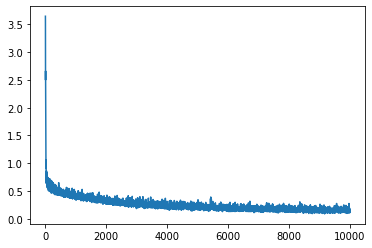

In [11]:
plt.plot(np.arange(epochs),losses)

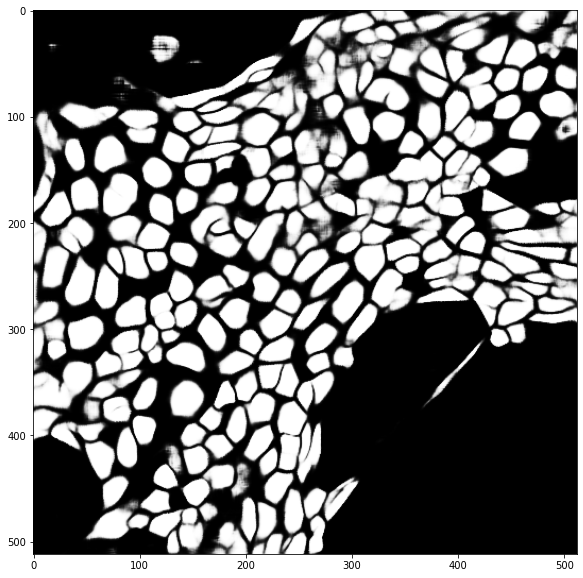

In [34]:
# try again with actual test image from our set
plt.rcParams["figure.figsize"] = (10,10)
model.eval()
testInput1 = "/project/trlab/imagePath/BzATP2 f1.tif"
test1 = cv2.imdecode(np.fromfile(testInput1, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
tensorTransform = T.ToTensor()
test1 = test1/255.0
test1 = test1.astype('float32')
img_tensor = tensorTransform(test1).unsqueeze(0).to('cuda')
output = model(img_tensor)
# insert this line when using bce with dice loss
output = torch.sigmoid(output)
output = output.squeeze()
output = output.detach().cpu().numpy()
plt.imshow(output, cmap='gray')
plt.show()

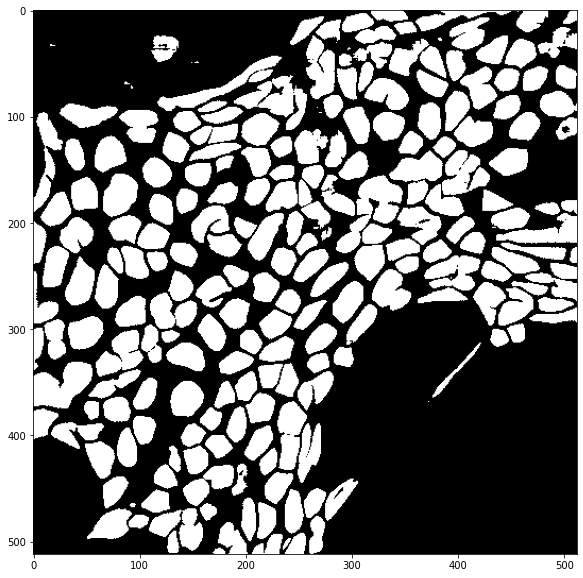

In [47]:
#scaledOut = output/np.amax(output)
ret, thresh1 = cv2.threshold(output, 0.5, 1, cv2.THRESH_BINARY)
plt.imshow(thresh1, cmap='gray')
predMask = thresh1

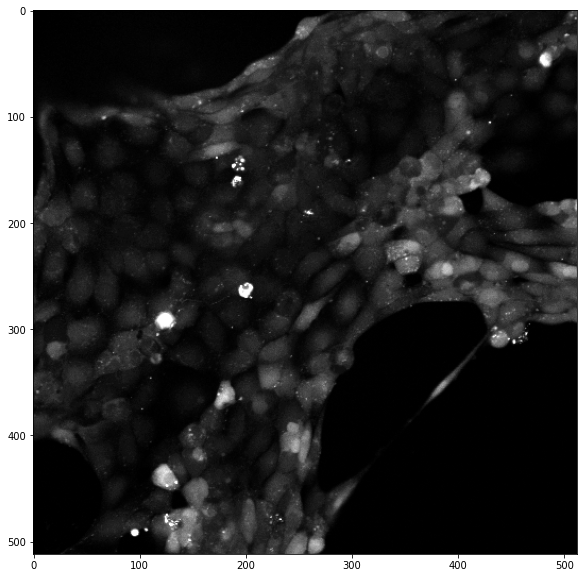

In [48]:
plt.imshow(test1, cmap='gray')

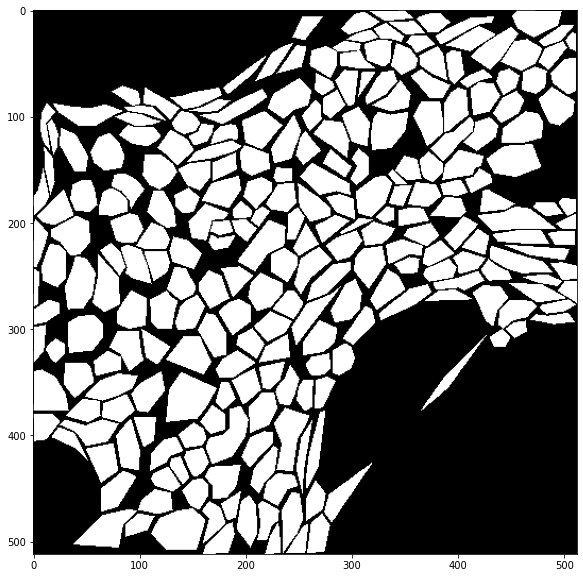

In [49]:
gt_mask = cv2.imdecode(np.fromfile("/project/trlab/maskPath/BzATP2 f1 mask.tif", dtype=np.uint8), cv2.IMREAD_UNCHANGED)
gt_mask = gt_mask/255
plt.imshow(gt_mask, cmap='gray')

In [50]:
# calculate intersection over union
tp=0
fp=0
fn=0
for i in range(len(gt_mask)):
    for j in range(len(gt_mask[0])):
        if gt_mask[i][j] == 1 and predMask[i][j] == 1:
            tp += 1
        elif gt_mask[i][j] == 0 and predMask[i][j] == 1:
            fp += 1
        elif gt_mask[i][j] == 1 and predMask[i][j] == 0:
            fn += 1

# Calculate IoU
iou = tp / (tp + fp + fn)
dice = (2*tp) / (2*tp + fp + fn)

print("iou:")
print(iou)

print("dice score:")
print(dice)

iou:
0.6650693891479923
dice score:
0.7988488569696245
